In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style Transfer

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('..')/'data/imagenet_sample/'
PATH_TRN = PATH/'train'
PATH_TRN

PosixPath('../data/imagenet_sample/train')

In [4]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

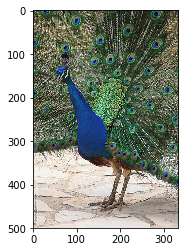

In [5]:
img_fn = PATH_TRN/'n01806143'/'n01806143_10015.JPEG'
img = open_image(img_fn)
plt.imshow(img)

In [6]:
sz=288

In [7]:
#Returns separate Transforms() of images for training and validation.
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

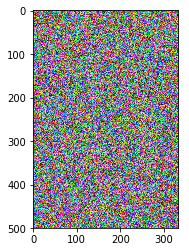

In [8]:
#generate a white note image
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img)

In [9]:
#JH noted issues with this resultion, found that smoothing helped loff function
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

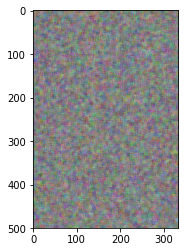

In [10]:
plt.imshow(opt_img)

In [11]:
#while val_tfms is a Transforms class, the result of trnsform on an image is an ndarray so is divisible
type(val_tfms), type(val_tfms(opt_img))

(fastai.transforms.Transforms, numpy.ndarray)

In [12]:
val_tfms(opt_img).shape

(3, 288, 288)

In [13]:
#why do we divide transforms by 2?
opt_img = val_tfms(opt_img)/2
opt_img.shape

(3, 288, 288)

In [14]:
#If there’s a single input to an operation that requires gradient, its output will also require gradient. 
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [15]:
#m_vgg previously defined as vgg16
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [16]:
img_tfm[None].shape, VV(img_tfm[None]).shape

((1, 3, 288, 288), torch.Size([1, 3, 288, 288]))

In [17]:
#VV appears to create a variable for each item in a list
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [18]:
max_iter = 1000
show_iter = 100
#Limited-memory Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm
#second order method using gradients and Hessian https://stats.stackexchange.com/questions/284712/how-does-the-l-bfgs-work
#typically we dont use 2nd order optim in DL but here optimizing pixels, not weights and this works
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [19]:
def actn_loss(x):
    #multiplying by 1000 (arbitary) so we dont round to zero
    return F.mse_loss(m_vgg(x), targ_v)*1000

In [20]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter == 0:
        print(f'Iteration: {n_iter}, loss {loss.data[0]}')
    return loss

In [21]:
n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, actn_loss))

Iteration: 100, loss 0.9606620073318481
Iteration: 200, loss 0.4697735905647278
Iteration: 300, loss 0.33641722798347473
Iteration: 400, loss 0.2726120948791504
Iteration: 500, loss 0.2359437197446823
Iteration: 600, loss 0.21325695514678955
Iteration: 700, loss 0.19785869121551514
Iteration: 800, loss 0.18617843091487885
Iteration: 900, loss 0.17642876505851746
Iteration: 1000, loss 0.16841374337673187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


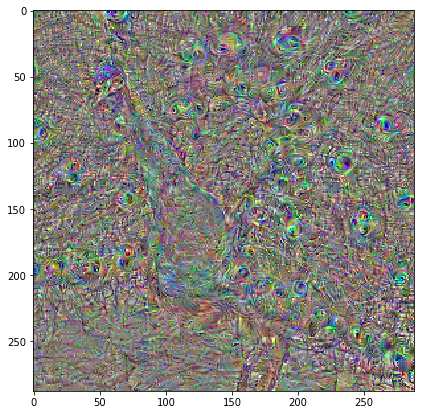

In [22]:
#here rollaxis moves elements of axis 1 to axis 4
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x)

## Forward Hook

In [23]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        #store output in features attribute
        self.features = output
    def close(self):
        self.hook.remove()

In [24]:
#exactly same as start of this NB
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [25]:
#find all layers before max pools
#these will be the most complete representation at a particlar cell size
#good places to grab content loss from
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o, nn.MaxPool2d)]

In [26]:
block_ends

[5, 12, 22, 32, 42]

In [27]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [28]:
children(m_vgg)[block_ends[3]]

ReLU(inplace)

In [29]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [30]:
opt_img_v, optimizer = get_opt()

In [31]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [32]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [33]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step, actn_loss2))

Iteration: 100, loss 0.1485176980495453
Iteration: 200, loss 0.06267555803060532
Iteration: 300, loss 0.04041263833642006
Iteration: 400, loss 0.030404500663280487
Iteration: 500, loss 0.0248367078602314
Iteration: 600, loss 0.02124643325805664
Iteration: 700, loss 0.018719961866736412
Iteration: 800, loss 0.016787221655249596
Iteration: 900, loss 0.015286944806575775
Iteration: 1000, loss 0.01414131373167038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


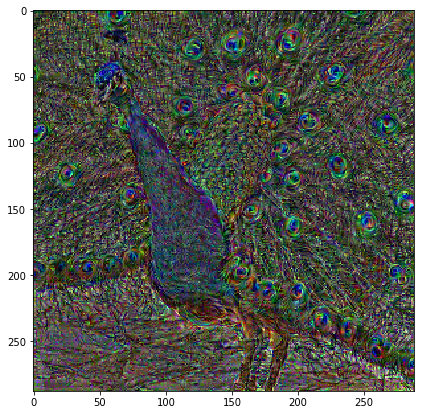

In [34]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize = (7,7))
plt.imshow(x)

In [35]:
sf.close()

## Style Match

In [36]:
#style_fn = PATH/'style'/'VanGogh-starry_night_291x483.jpg'
style_fn = PATH/'style'/'Kandinsky_CompositionVII.jpg'

In [37]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((712, 1071, 3), (500, 334, 3))

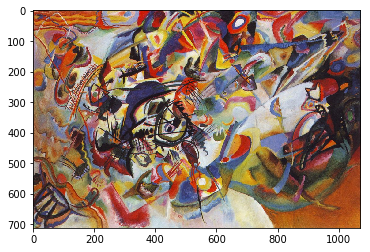

In [38]:
plt.imshow(style_img)

In [39]:
#used GIMP to scale instead of this fn
def scale_match(src, targ):
    h,w,_ = img.shape
    sh,sw,_ = style_img.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(style_img, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [40]:
style = scale_match(img, style_img)

((500, 334, 3), (500, 334, 3))

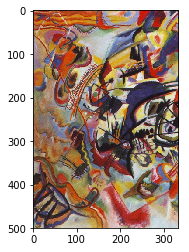

In [41]:
plt.imshow(style)
style.shape, img.shape

In [42]:
opt_img_v, optimizer = get_opt()

In [43]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [44]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [45]:
style_tfm = val_tfms(style_img)

In [46]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [47]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    return F.mse_loss(gram(input), gram(target))

In [48]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [49]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step,style_loss))

Iteration: 100, loss 312.1615905761719
Iteration: 200, loss 85.9656982421875
Iteration: 300, loss 40.52235412597656
Iteration: 400, loss 25.116912841796875
Iteration: 500, loss 17.768321990966797
Iteration: 600, loss 13.612722396850586
Iteration: 700, loss 11.024967193603516
Iteration: 800, loss 9.316596031188965
Iteration: 900, loss 8.134353637695312
Iteration: 1000, loss 7.2749128341674805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


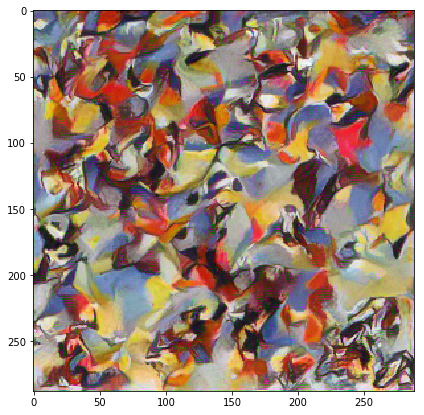

In [50]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x)

In [51]:
for sf in sfs: 
    sf.close()

## Style Transfer

In [89]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [90]:
opt_img_v, optimizer = get_opt()

In [91]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss = F.mse_loss(outs[3], targ_vs[3])*800000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [92]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step, comb_loss))

Iteration: 100, loss 2181.50927734375
Iteration: 200, loss 1399.2386474609375
Iteration: 300, loss 1130.77197265625
Iteration: 400, loss 997.3140258789062
Iteration: 500, loss 920.9342041015625
Iteration: 600, loss 871.7665405273438
Iteration: 700, loss 835.466064453125
Iteration: 800, loss 807.9846801757812
Iteration: 900, loss 785.0715942382812
Iteration: 1000, loss 766.9390869140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


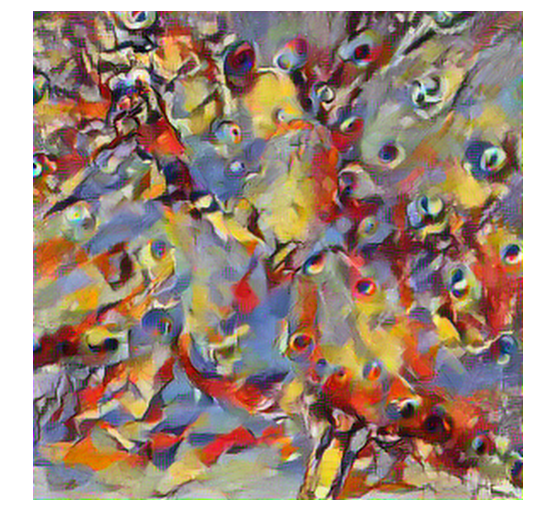

In [93]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off')
plt.savefig('Peacock_Kandinsky_CompositionVII_content_8x1e5.png')

In [94]:
for sf in sfs: 
    sf.close()